In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet, inconsistent
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score, silhouette_samples
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
from joblib import Parallel, delayed

import utils as lu
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/figures4/utils.py'>

# Directories

In [2]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directory of FISH data
dir_fish = '/home/louiscam/projects/gpcr/data/fish_data/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

In [3]:
# Load gene to chromosome directory
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)
# Load gene to locus directory
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)

# Load MERFISH data

In [4]:
# Load data
merfish_data = pd.read_csv(dir_fish+'dna_merfish_data.tsv', sep='\t', header=0)

In [5]:
# Build dictionary from Ensembl gene name to HGNC
enst2hgnc_df = pd.read_csv(dir_genome+'ensemblGene2Name', sep='\t', header=0)
enst2hgnc_df.columns = ['ENST', 'HGNC']
enst2hgnc_df = enst2hgnc_df.set_index('ENST')
ensg2enst_df = pd.read_csv(dir_genome+'ensemblGene2Transcript2Protein', sep='\t', header=0)
ensg2enst_df.columns = ['ENSG', 'ENST', 'ENSP']
ensg2enst_df = ensg2enst_df[['ENSG', 'ENST']]
ensg2enst_df = ensg2enst_df.set_index('ENST')
ensg2hgnc_df = ensg2enst_df.join(enst2hgnc_df, how='outer').reset_index()
ensg2hgnc_df = ensg2hgnc_df[['ENSG', 'HGNC']].drop_duplicates(['ENSG', 'HGNC'])
ensg2hgnc_df['HGNC'] = ensg2hgnc_df['HGNC'].str.upper()
ensg2hgnc_df = ensg2hgnc_df.reset_index()[['ENSG', 'HGNC']]
ensg2hgnc = {ensg2hgnc_df.loc[i,'ENSG']: ensg2hgnc_df.loc[i,'HGNC'] for i in range(len(ensg2hgnc_df))}

In [6]:
# Add gene information to MERFISH data
merfish_data['gene names'] = merfish_data['gene names'].astype(str)
merfish_data['gene names'] = merfish_data['gene names'].apply(lambda x: x.split(',') if x!='nan' else [])
merfish_data['gene_hgnc'] = merfish_data['gene names'].apply(lambda x: [ensg2hgnc[g] if (g in ensg2hgnc.keys()) 
                                                                    else 'unknown' for g in x] if len(x)>0 else [])
merfish_data['n_genes'] = merfish_data['gene_hgnc'].apply(lambda x: len(x))

merfish_data['transciption'] = merfish_data['transciption'].astype(str)
merfish_data['transciption'] = merfish_data['transciption'].apply(lambda x: x.split(',') if x!='nan' else [])

merfish_data['chrom'] = merfish_data['genomic coordinate'].str.split(':', expand=True)[0]
merfish_data['loc'] = merfish_data['genomic coordinate'].str.split(':', expand=True)[1]
merfish_data['start'] = merfish_data['loc'].str.split('-', expand=True)[0].astype(int)
merfish_data['end'] = merfish_data['loc'].str.split('-', expand=True)[1].astype(int)
merfish_data['length (kb)'] = (merfish_data['end']-merfish_data['start'])/1000

In [7]:
# Reduce data (drop NAs, chrX and gene-less loci)
subset = ['z(nm)', 'x(nm)', 'y(nm)', 'genomic coordinate', 'cell number', 'experiment number']
merfish_data = merfish_data.dropna(how='any', subset=subset)
merfish_data = merfish_data[merfish_data['chrom']!='chrX']
merfish_data = merfish_data[['cell number',
                             'chrom',
                             'homolog number',
                             'genomic coordinate',
                             'length (kb)',
                             'gene_hgnc',
                             'transciption',
                             'x(nm)', 'y(nm)', 'z(nm)']]
merfish_data.columns = [ 'cell_ID',
                         'chrom',
                         'homolog',
                         'probe_locus',
                         'probe_length(kb)',
                         'gene_ID',
                         'transcription',
                         'x(nm)', 'y(nm)', 'z(nm)']

In [8]:
# Print basic statistics
print(f'Total number of cells = {len(np.unique(merfish_data["cell_ID"].values))}')
print(f'Total number of probe loci = {len(np.unique(merfish_data["probe_locus"].values))}')
print(f'Unique probe loci lengths: {np.unique(merfish_data["probe_length(kb)"].values, return_counts=True)}')

Total number of cells = 3668
Total number of probe loci = 990
Unique probe loci lengths: (array([100.]), array([5797522]))


# Load adhesome genes

In [9]:
# Load all adhesome genes
with open(saving_dir+'all_adhesome_genes.pkl', 'rb') as f:
    all_adhesome_genes = pickle.load(f)
# Load active adhesome genes
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
# Load adhesome TF genes and loci
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)
selected_genes = np.concatenate([active_adhesome_genes, active_lung_adhesome_tf_genes])
print(f'Number of selected genes = {len(selected_genes)}')

Number of selected genes = 228


In [10]:
# Location of genes in hg38
df_loc = pd.read_csv(dir_genome+'chrom_hg38.loc', sep='\t', header=0)
df_loc = df_loc[df_loc['#chrom'].isin(['chr'+str(i) for i in range(1,23)])]
df_loc = df_loc[['#chrom', 'chromStart', 'chromEnd', 'geneName']]
df_loc.columns = ['chrom', 'start', 'end', 'geneName']
df_loc = df_loc.sort_values(['chrom','start','end'])
df_loc = df_loc.groupby(['chrom','geneName']).agg({'start':'min', 'end':'max'})
df_loc = df_loc.reset_index().sort_values(['chrom','start','end'])
df_loc_adhesome = df_loc[df_loc['geneName'].isin(selected_genes)]

In [11]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
df_loc_adhesome_hg19 = df_loc[df_loc['geneSymbol'].isin(selected_genes)]
df_loc_adhesome_hg19 = df_loc_adhesome_hg19[['geneSymbol', 'chromStart', 'chromEnd']]
df_loc_adhesome_hg19.columns = ['geneName', 'start', 'end']

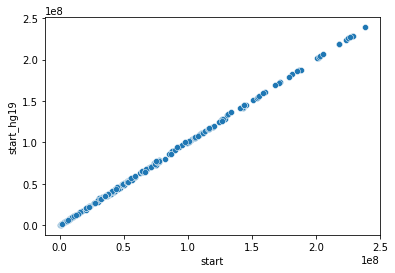

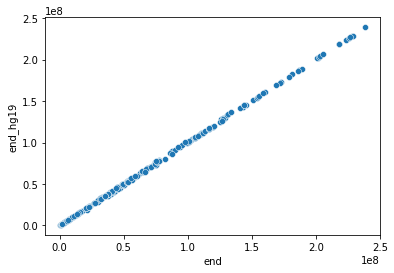

In [12]:
# Comparison
df_loc_adhesome = df_loc_adhesome.set_index('geneName')
df_loc_adhesome_hg19 = df_loc_adhesome_hg19.set_index('geneName')
combined_df_loc = df_loc_adhesome.join(other=df_loc_adhesome_hg19, on=['geneName'], how='inner', rsuffix='_hg19')

plt.figure()
sns.scatterplot(data=combined_df_loc,  x='start', y='start_hg19')
plt.show()

plt.figure()
sns.scatterplot(data=combined_df_loc,  x='end', y='end_hg19')
plt.show()

df_loc_adhesome = df_loc_adhesome.reset_index()
df_loc_adhesome_hg19 = df_loc_adhesome_hg19.reset_index()

# Identify adhesome MERFISH loci

In [13]:
# Identify MERFISH probes present within 500kb of available MERFISH probes
resol = 500000

In [14]:
# Construct a bed object for adhesome genes
df_adhesome_pos = df_loc_adhesome[['chrom','start','end', 'geneName']]
bed_adhesome = pybedtools.BedTool.from_dataframe(df_adhesome_pos).sort()
bed_adhesome_df = bed_adhesome.to_dataframe()

In [15]:
# Construct a bed object for MERFISH probes
df_merfish_pos = merfish_data.loc[:,'probe_locus'].to_frame().drop_duplicates()
df_merfish_pos['chrom'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[0]
df_merfish_pos['extent'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[1]
df_merfish_pos['start'] = df_merfish_pos['extent'].str.split('-', expand=True)[0].astype(int)
df_merfish_pos['end'] = df_merfish_pos['extent'].str.split('-', expand=True)[1].astype(int)
df_merfish_pos = df_merfish_pos[['chrom', 'start', 'end', 'probe_locus']]
df_merfish_pos['start'] = (df_merfish_pos['start']-resol).clip(lower=0)
df_merfish_pos['end'] = (df_merfish_pos['end']+resol)
bed_merfish = pybedtools.BedTool.from_dataframe(df_merfish_pos).sort()
bed_merfish_df = bed_merfish.to_dataframe()

In [16]:
# Get counts for this feature in the segmented genome
out = pybedtools.bedtool.BedTool.map(bed_merfish, bed_adhesome, c=[4], o='distinct', f=1e-9, F=0.5)
counts = out.to_dataframe()
counts['score'] = counts['score'].str.split(',')
counts['score'] = counts['score'].apply(lambda x: x if x[0]!='.' else [])
counts['n_adhesome_genes'] = counts['score'].apply(lambda x: len(x))
merfishloc2gene = {counts.loc[i,'name']: counts.loc[i,'score'] for i in range(len(counts))}

In [17]:
# Table of adhesome MERFISH probes
adhesome_probes_df = counts[counts['n_adhesome_genes']>0]
adhesome_MERFISH_genes = sorted(itertools.chain.from_iterable(adhesome_probes_df['score']))
adhesome_MERFISH_probes = adhesome_probes_df["name"].values
print(f'Number of adhesome MERFISH probes = {len(adhesome_MERFISH_probes)}')
print(f'Number of adhesome genes covered by MERFISH probes = {len(adhesome_MERFISH_genes)}')
print(f'Adhesome genes covered by MERFISH probes = {adhesome_MERFISH_genes}')

Number of adhesome MERFISH probes = 82
Number of adhesome genes covered by MERFISH probes = 95
Adhesome genes covered by MERFISH probes = ['ABI1', 'ACTB', 'ACTN1', 'ADAM12', 'AKT1', 'ARF1', 'ARHGAP32', 'ARHGEF12', 'ARHGEF2', 'ARHGEF7', 'ASAP2', 'ASAP3', 'BCAR1', 'BDP1', 'BRF1', 'CASP8', 'CASS4', 'CAV1', 'CD47', 'CEBPB', 'CFL1', 'CRKL', 'CSRP1', 'CTCF', 'DNM2', 'EP300', 'EZR', 'FHL2', 'GIT1', 'GRB2', 'GRB7', 'INPPL1', 'INSR', 'ITGA3', 'ITGA5', 'ITGB1', 'ITGB1BP1', 'ITGB2', 'ITGB3', 'ITGB3BP', 'KEAP1', 'LDB3', 'LPP', 'LRP1', 'MACF1', 'MAPK1', 'MAPK8', 'MARCKS', 'MAZ', 'MYH9', 'NEXN', 'NF2', 'NRP1', 'OSTF1', 'PARVA', 'PARVB', 'PDE4D', 'PFN1', 'PIAS4', 'PIP5K1C', 'PLAUR', 'PLEC', 'POLR2A', 'PPM1F', 'PRKACA', 'PTK2', 'PTK2B', 'PTPN1', 'PTPN12', 'PTPRO', 'RAC1', 'RAD21', 'RAPGEF1', 'RASA1', 'RAVER1', 'RB1', 'RBL1', 'RBL2', 'RNF185', 'SHARPIN', 'SIRPA', 'SLC16A3', 'SLC3A2', 'SLC9A1', 'SORBS2', 'SOS1', 'STARD13', 'STAT3', 'SUMO2', 'SVIL', 'TESK1', 'TIAM1', 'TLN1', 'TP53', 'VASP']


# Identify adhesome MERFISH HiC loci

In [18]:
# Construct a bed object for MERFISH probes
df_merfish_pos = merfish_data.loc[:,'probe_locus'].to_frame().drop_duplicates()
df_merfish_pos['chrom'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[0]
df_merfish_pos['extent'] = df_merfish_pos['probe_locus'].str.split(':', expand=True)[1]
df_merfish_pos['start'] = df_merfish_pos['extent'].str.split('-', expand=True)[0].astype(int)
df_merfish_pos['end'] = df_merfish_pos['extent'].str.split('-', expand=True)[1].astype(int)
df_merfish_pos = df_merfish_pos[['chrom', 'start', 'end', 'probe_locus']]
df_merfish_pos = df_merfish_pos[df_merfish_pos['probe_locus'].isin(adhesome_MERFISH_probes)]
bed_merfish = pybedtools.BedTool.from_dataframe(df_merfish_pos).sort()
bed_merfish_df = bed_merfish.to_dataframe()

In [19]:
# Divide genome into portions corresponding to loci
resol = 250000
df_sizes = lu.get_chrom_sizes(dir_genome, resol)
chr_list = np.arange(1, 22+1)
df_chrom_list = []
for chrom in chr_list:
    # Get chromosome size
    chrom_size = int(df_sizes.loc[df_sizes['chr']==str(chrom)]['size'])
    # Divide the chromosome into segments of HIC_RESOLN length
    stop_pos = np.arange(resol, chrom_size + resol, resol, dtype = 'int')
    df_chrom = pd.DataFrame()
    df_chrom['chrom'] = ['chr' + str(chrom)]*len(stop_pos)
    df_chrom['start'] = stop_pos - resol
    df_chrom['stop'] = stop_pos
    df_chrom_list.append(df_chrom)
all_loci_pos = pd.concat(df_chrom_list, axis=0)
all_loci_pos['name'] = ['chr_'+all_loci_pos.iloc[i]['chrom'].split('chr')[1]+'_loc_'+str(all_loci_pos.iloc[i]['start'])
                          for i in range(all_loci_pos.shape[0])]

# Convert all_loci_pos to bed file
bed_all_loci = pybedtools.BedTool.from_dataframe(all_loci_pos)
bed_all_loci = bed_all_loci.sort()
bed_all_loci_df = bed_all_loci.to_dataframe()

In [20]:
# Get counts for this feature in the segmented genome
out = pybedtools.bedtool.BedTool.map(bed_merfish, bed_all_loci, c=[4], o='distinct', f=0.5, F=1e-9)
counts = out.to_dataframe()
counts['score'] = counts['score'].str.split(',')
counts['score'] = counts['score'].apply(lambda x: x if x[0]!='.' else [])
counts['n_loci'] = counts['score'].apply(lambda x: len(x))
merfishloc2hicloc = {counts.loc[i,'name']: counts.loc[i,'score'] for i in range(len(counts))}

In [21]:
# Drop probes
probes2drop = counts[counts['n_loci']==0]['name'].values
adhesome_MERFISH_probes = [probe for probe in adhesome_MERFISH_probes if (probe not in probes2drop)]

# Create adhesome MERFISH heatmap

### Create heatmap

In [22]:
# Select MERFISH data corresponding to active adhesome genes
selected_merfish_data = merfish_data.copy()
selected_merfish_data = selected_merfish_data.loc[
    selected_merfish_data['probe_locus'].isin(adhesome_MERFISH_probes), :
]

In [23]:
# A few statistics
all_merfish_loci = np.unique(selected_merfish_data["probe_locus"])
all_merfish_cells = np.unique(selected_merfish_data["cell_ID"])
print(f'Number of unique loci = {len(all_merfish_loci)}')
print(f'Number of unique cells = {len(all_merfish_cells)}')

Number of unique loci = 81
Number of unique cells = 3668


In [24]:
# Build a dictionary where for each cell, we report a probe by probe distance matrix between adhesome genes
cell2distmat = {}
n_duplicates = []
for cell in tqdm(all_merfish_cells):
    cell_data = selected_merfish_data.loc[selected_merfish_data['cell_ID']==cell,
                                          ['x(nm)','y(nm)','z(nm)','probe_locus']]
    n_duplicates = n_duplicates+cell_data.groupby('probe_locus').size().tolist()
    cell_data = cell_data.groupby('probe_locus').agg({'x(nm)': 'mean', 'y(nm)': 'mean', 'z(nm)': 'mean'})
    dist_mat = squareform(pdist(cell_data, metric='euclidean'))
    cell2distmat[cell] = pd.DataFrame(dist_mat,columns = cell_data.index.values, index = cell_data.index.values)
# Checking that we have at most 2 measurements for each probe, corresponding to the 2 chromosome homologs
print(np.unique(n_duplicates, return_counts=True))

100%|██████████| 3668/3668 [00:13<00:00, 280.10it/s]

(array([1, 2]), array([ 53742, 234227]))


In [25]:
# Combine information across all cells into one dataframe
distances_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
n_samples_df = pd.DataFrame(0, columns=all_merfish_loci, index=all_merfish_loci)
for cell in tqdm(all_merfish_cells):
    cell_dist_mat = cell2distmat[cell]
    cell_idx = cell_dist_mat.index.values
    distances_df.loc[cell_idx, cell_idx] += cell_dist_mat
    n_samples_df.loc[cell_idx, cell_idx] += 1 
n_samples_df = n_samples_df.replace(0, np.nan)

100%|██████████| 3668/3668 [00:14<00:00, 256.82it/s]


In [26]:
# Average distance dataframe
avg_dist_df = distances_df/n_samples_df
print(f'Maximum average distance = {avg_dist_df.max().max()}')
avg_scaled_dist_df = avg_dist_df/avg_dist_df.max().max()
avg_scaled_prox_df = 1-avg_scaled_dist_df

Maximum average distance = 6968.415433364333


### Cluster heatmap

In [27]:
# Create graph from distance matrix
G = nx.from_pandas_adjacency(avg_scaled_prox_df)
dist_merfish = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='weight').todense())
np.fill_diagonal(dist_merfish,0)
y = dist_merfish[np.triu_indices(n=len(dist_merfish),k=1)]
print(f'Number of nodes = {len(G.nodes)}')
print(f'Number of edges = {len(G.edges)}')

Number of nodes = 81
Number of edges = 3320


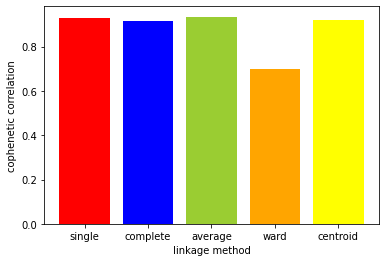

In [28]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_single = cophenet(linkage(y, method='single'), y)[0]
cophenet_complete = cophenet(linkage(y, method='complete'), y)[0]
cophenet_average = cophenet(linkage(y, method='average'), y)[0]
cophenet_ward = cophenet(linkage(y, method='ward'), y)[0]
cophenet_centroid = cophenet(linkage(y, method='centroid'), y)[0]
plt.figure()
plt.bar(x=['single', 'complete', 'average', 'ward', 'centroid'],
        height = [cophenet_single, cophenet_complete, cophenet_average, cophenet_ward, cophenet_centroid],
        color = ['red', 'blue', 'yellowgreen', 'orange', 'yellow'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
# plt.savefig(saving_supp_dir+f'suppfig_7c_{norm}.pdf', format='pdf')
plt.show()

100%|██████████| 101/101 [00:00<00:00, 132.12it/s]


Threshold = 0.67


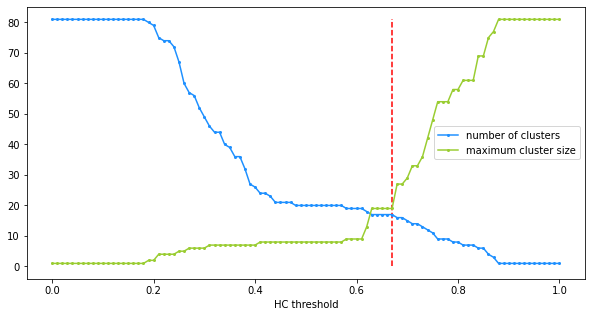

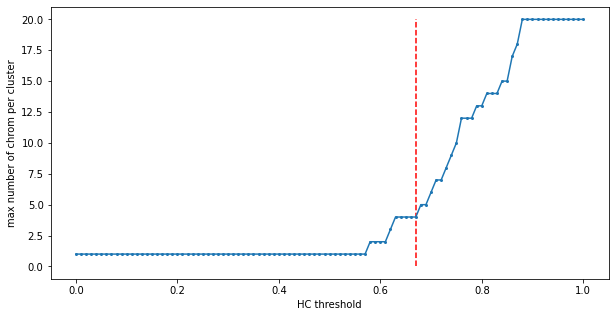

In [29]:
# Pick clustering threshold
criterion='distance'
linked1 = linkage(y, method='average')
threshold_list = np.arange(0,1+0.01,0.01)
n_clusters = []
max_probes_per_cluster = []
max_chrom_per_cluster = []
for hc_threshold in tqdm(threshold_list):
    # Cluster
    clustering1 = fcluster(linked1, t=hc_threshold, criterion=criterion)
    # Create graph with metadata
    G_tmp = G.copy()
    labels = np.array(sorted(G_tmp.nodes))
    n = len(labels)
    nx.set_node_attributes(G_tmp, {labels[i]: str(clustering1[i]) for i in range(n)}, "cluster")
    nx.set_node_attributes(G_tmp, {labels[i]: labels[i].split(':')[0] for i in range(n)}, "chromosome")
    # Record results
    n_clusters.append(len(np.unique(clustering1)))
    max_probes_per_cluster.append(np.max(np.unique(clustering1, return_counts=True)[1]))
    max_chrom_per_cluster.append(oi.get_networkx_graph_as_dataframe_of_nodes(G_tmp).groupby('cluster')['chromosome'].nunique().max())
n_clusters = np.array(n_clusters)
max_probes_per_cluster = np.array(max_probes_per_cluster)
max_chrom_per_cluster = np.array(max_chrom_per_cluster)

# Performance of different HC thresholds
t_critic = threshold_list[np.min(np.where(np.array(max_chrom_per_cluster)>4)[0])-1]
print('Threshold = '+str(t_critic))

plt.figure(figsize=(10,5))
plt.plot(threshold_list, n_clusters, 
         marker='o', markersize=2, color='dodgerblue', label='number of clusters')
plt.plot(threshold_list, max_probes_per_cluster, 
         marker='o', markersize=2, color='yellowgreen', label='maximum cluster size')
plt.vlines(x=t_critic, ymin=0, ymax=max(n_clusters), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('')
plt.legend(loc='center right')
# plt.savefig(saving_main_dir+f'fig_5b_{norm}.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(threshold_list, max_chrom_per_cluster,
         marker='o', markersize=2)
plt.vlines(x=t_critic, ymin=0, ymax=max(max_chrom_per_cluster), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('max number of chrom per cluster')
# plt.savefig(saving_main_dir+f'fig_5a_{norm}.pdf', format='pdf')
plt.show()

In [30]:
# Run hierarchical clustering
linked_merfish = linkage(y, method='average')
clust_merfish = fcluster(linked_merfish, t_critic, criterion=criterion)

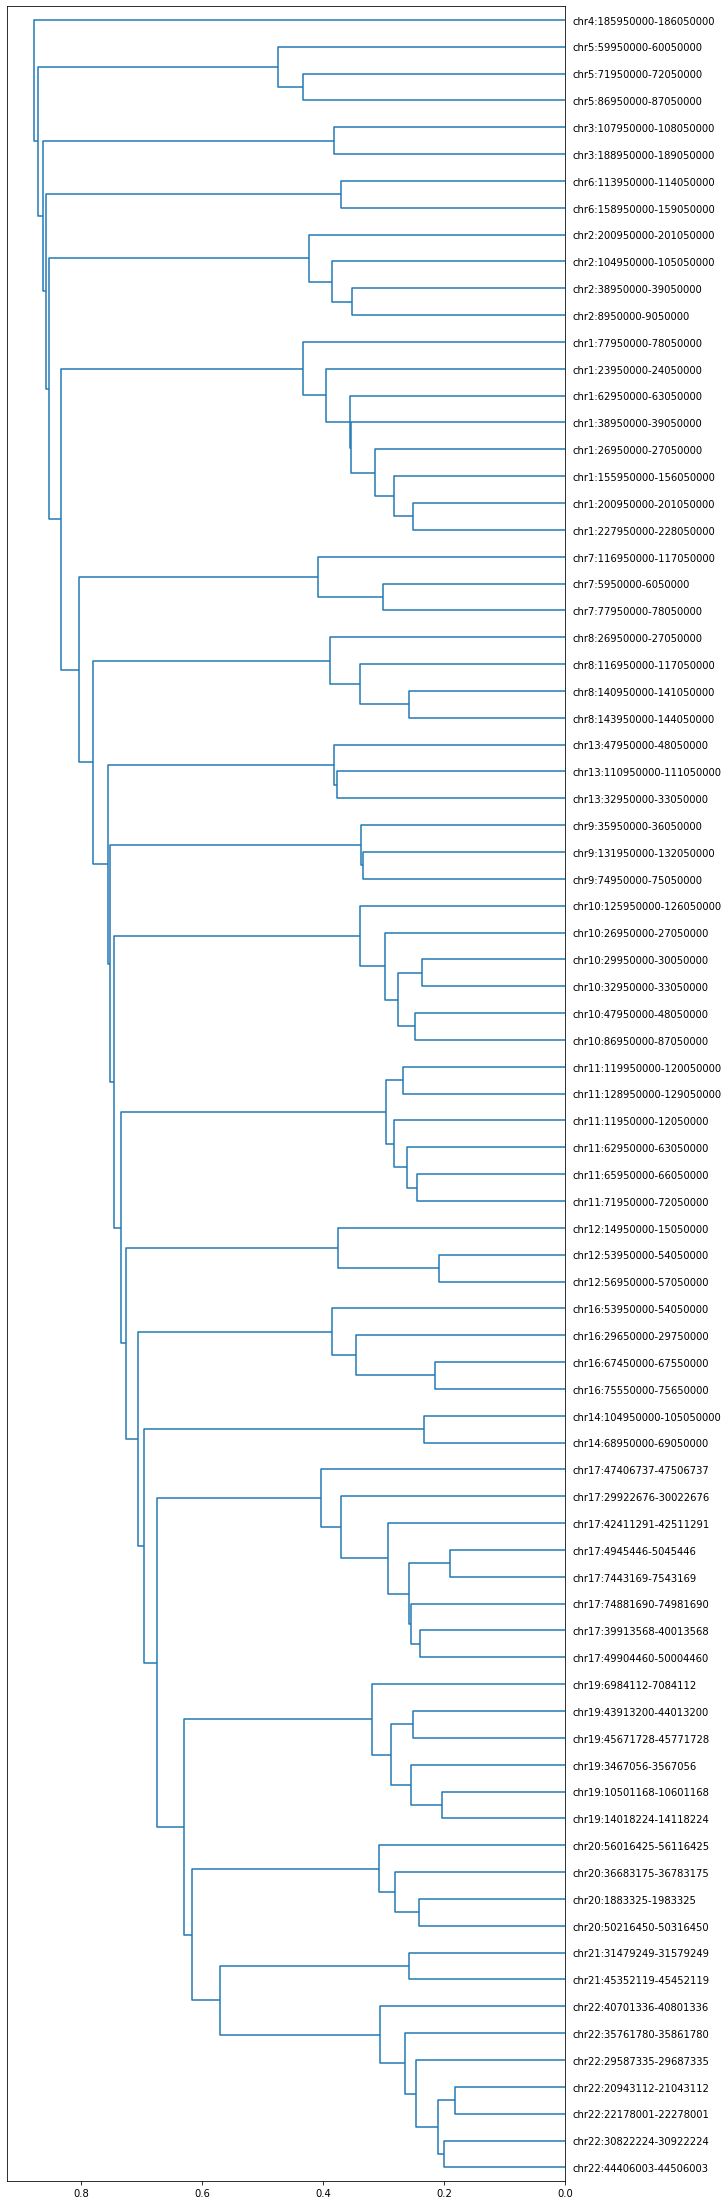

In [31]:
# Plot full dendrogram
plt.figure(figsize=(10, 40))
dendrogram( linked_merfish,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            color_threshold=0)
# plt.savefig(saving_supp_dir+f'suppfig_7d_{norm}.pdf', format='pdf')
plt.show()

In [32]:
# Identify which nodes are in non-singleton clusters
probe_clusters_df = pd.DataFrame({'probe': sorted(G.nodes), 'cluster': clust_merfish})
nonsingleton_cluster_ids = set([c for c in list(clust_merfish) if list(clust_merfish).count(c)>1])
nonsingleton_probes = probe_clusters_df[probe_clusters_df['cluster'].isin(nonsingleton_cluster_ids)]['probe'].values

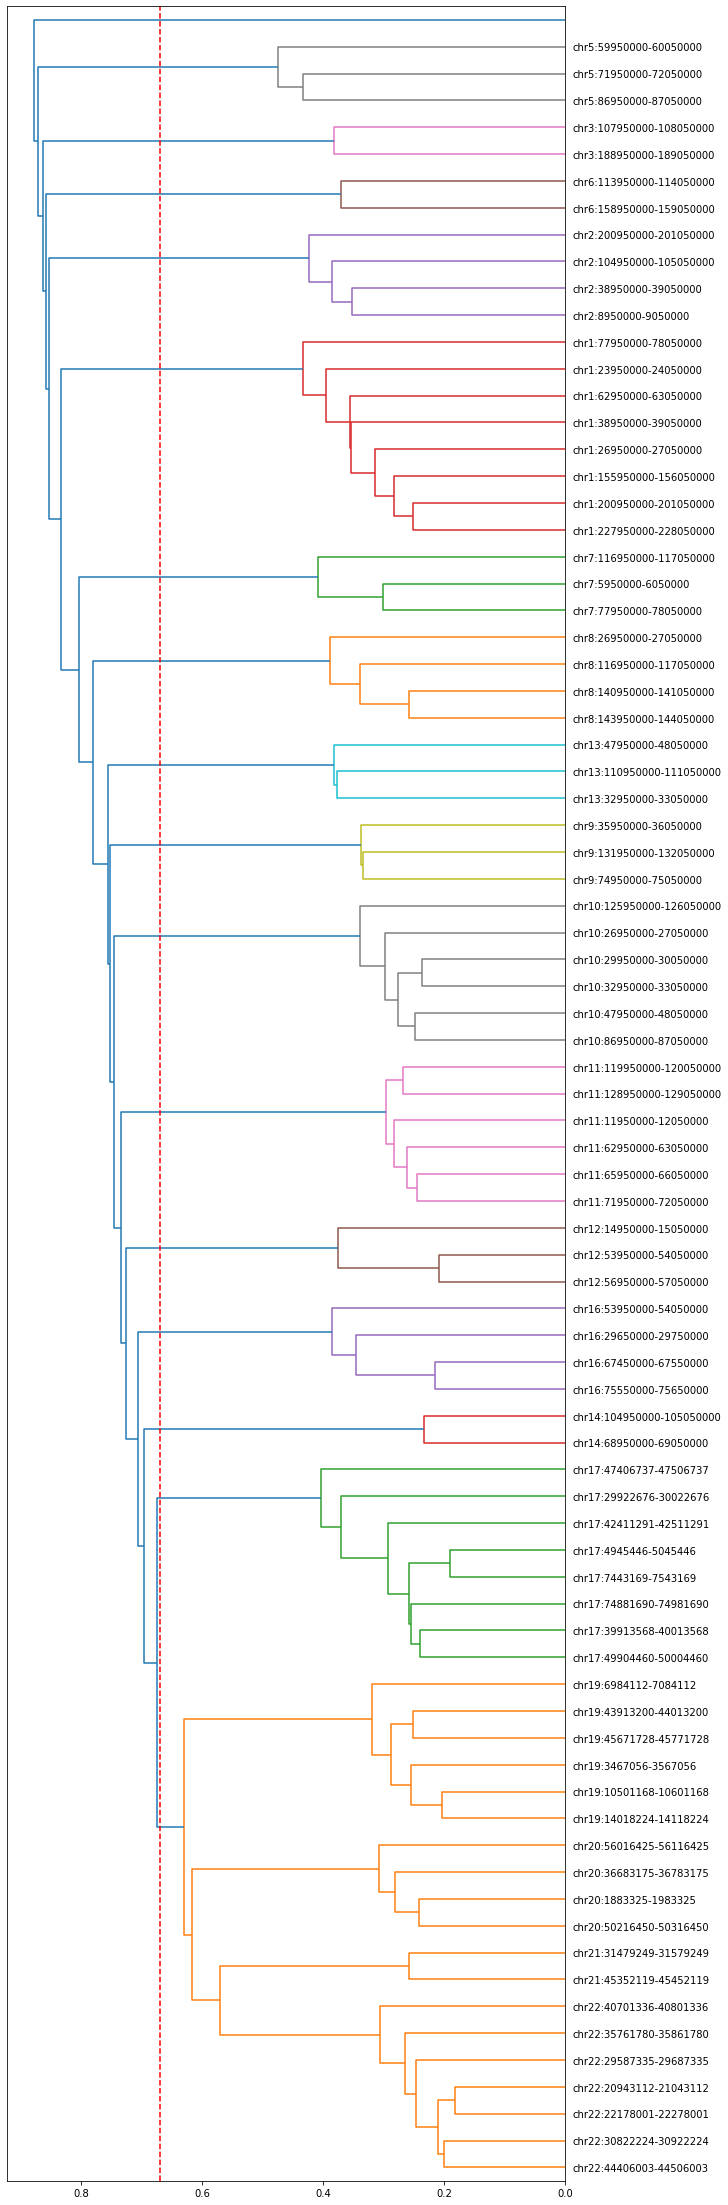

In [33]:
# Call dendrogram to get the returned dictionary and compute label function
R1 = dendrogram(linked_merfish, labels=sorted(G.nodes), no_plot=True)
R2 = []
for i in range(len(R1['ivl'])):
    if (R1['ivl'][i] in nonsingleton_probes):
        R2.append(R1['ivl'][i])
    else:
        R2.append('')
# Create a label dictionary
temp = {
    R1['leaves'][ii]: R2[ii] 
    for ii in range(len(R1['leaves']))
}
def llf(xx):
    return temp[xx]

plt.figure(figsize=(10, 40))
dendrogram(linked_merfish,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            leaf_label_func=llf,
            color_threshold=t_critic)
plt.vlines(x=t_critic, ymin=0, ymax=4000, color='red', linestyle='dashed')
# plt.savefig(saving_main_dir+f'fig_5c_{norm}.pdf', format='pdf')
plt.show()

# Create adhesome HiC heatmap

### Create heatmap

In [34]:
# Compute corresponding Hi-C matrix
contacts_df = pd.DataFrame(0, index=adhesome_MERFISH_probes, columns=adhesome_MERFISH_probes)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.product(chr_list, chr_list))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    
    if chr1<=chr2:
        # Select loci on chr1 and chr2
        probes_chr1 = [probe for probe in adhesome_MERFISH_probes if ('chr'+str(chr1)+':') in probe]
        probes_chr2 = [probe for probe in adhesome_MERFISH_probes if ('chr'+str(chr2)+':') in probe]

        # Load HiC data for this chromosome pair
        processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
        with open(dir_processed_hic+processed_hic_filename, 'rb') as f:
            hic_chpair_df = pickle.load(f)

        # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
        probe_id_pairs = itertools.product(probes_chr1, probes_chr2)
        for probe1_id, probe2_id in probe_id_pairs:
            loci_probe1 = [int(locus_id.split('_')[3]) for locus_id in merfishloc2hicloc[probe1_id]]
            loci_probe2 = [int(locus_id.split('_')[3]) for locus_id in merfishloc2hicloc[probe2_id]]
            contacts_df.loc[probe1_id, probe2_id] = hic_chpair_df.loc[loci_probe1,loci_probe2].mean().mean()
# Symmetrize data frame
hic_prox_df = contacts_df+contacts_df.T
hic_scaled_prox_df = hic_prox_df/hic_prox_df.max().max()
hic_scaled_dist_df = 1-hic_scaled_prox_df

100%|██████████| 484/484 [00:10<00:00, 47.89it/s]


### Cluster heatmap

In [35]:
# Create graph from distance matrix
G = nx.from_pandas_adjacency(hic_scaled_prox_df)
dist_hic = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='weight').todense())
np.fill_diagonal(dist_hic,0)
y = dist_hic[np.triu_indices(n=len(dist_hic),k=1)]
print(f'Number of nodes = {len(G.nodes)}')
print(f'Number of edges = {len(G.edges)}')

Number of nodes = 81
Number of edges = 2944


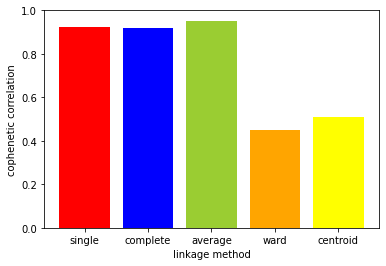

In [36]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_single = cophenet(linkage(y, method='single'), y)[0]
cophenet_complete = cophenet(linkage(y, method='complete'), y)[0]
cophenet_average = cophenet(linkage(y, method='average'), y)[0]
cophenet_ward = cophenet(linkage(y, method='ward'), y)[0]
cophenet_centroid = cophenet(linkage(y, method='centroid'), y)[0]
plt.figure()
plt.bar(x=['single', 'complete', 'average', 'ward', 'centroid'],
        height = [cophenet_single, cophenet_complete, cophenet_average, cophenet_ward, cophenet_centroid],
        color = ['red', 'blue', 'yellowgreen', 'orange', 'yellow'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
# plt.savefig(saving_supp_dir+f'suppfig_7c_{norm}.pdf', format='pdf')
plt.show()

100%|██████████| 101/101 [00:00<00:00, 134.38it/s]


Threshold = 0.9400000000000001


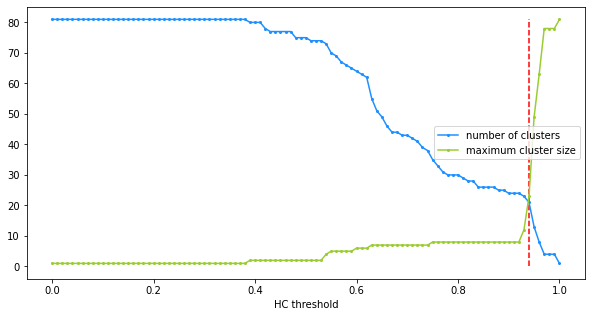

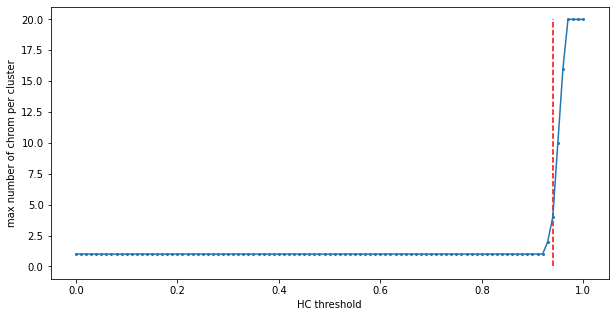

In [37]:
# Pick clustering threshold
criterion='distance'
linked1 = linkage(y, method='average')
threshold_list = np.arange(0,1+0.01,0.01)
n_clusters = []
max_probes_per_cluster = []
max_chrom_per_cluster = []
for hc_threshold in tqdm(threshold_list):
    # Cluster
    clustering1 = fcluster(linked1, t=hc_threshold, criterion=criterion)
    # Create graph with metadata
    G_tmp = G.copy()
    labels = np.array(sorted(G_tmp.nodes))
    n = len(labels)
    nx.set_node_attributes(G_tmp, {labels[i]: str(clustering1[i]) for i in range(n)}, "cluster")
    nx.set_node_attributes(G_tmp, {labels[i]: labels[i].split(':')[0] for i in range(n)}, "chromosome")
    # Record results
    n_clusters.append(len(np.unique(clustering1)))
    max_probes_per_cluster.append(np.max(np.unique(clustering1, return_counts=True)[1]))
    max_chrom_per_cluster.append(oi.get_networkx_graph_as_dataframe_of_nodes(G_tmp).groupby('cluster')['chromosome'].nunique().max())
n_clusters = np.array(n_clusters)
max_probes_per_cluster = np.array(max_probes_per_cluster)
max_chrom_per_cluster = np.array(max_chrom_per_cluster)

# Performance of different HC thresholds
t_critic = threshold_list[np.min(np.where(np.array(max_chrom_per_cluster)>4)[0])-1]
print('Threshold = '+str(t_critic))

plt.figure(figsize=(10,5))
plt.plot(threshold_list, n_clusters, 
         marker='o', markersize=2, color='dodgerblue', label='number of clusters')
plt.plot(threshold_list, max_probes_per_cluster, 
         marker='o', markersize=2, color='yellowgreen', label='maximum cluster size')
plt.vlines(x=t_critic, ymin=0, ymax=max(n_clusters), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('')
plt.legend(loc='center right')
# plt.savefig(saving_main_dir+f'fig_5b_{norm}.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(threshold_list, max_chrom_per_cluster,
         marker='o', markersize=2)
plt.vlines(x=t_critic, ymin=0, ymax=max(max_chrom_per_cluster), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('max number of chrom per cluster')
# plt.savefig(saving_main_dir+f'fig_5a_{norm}.pdf', format='pdf')
plt.show()

In [38]:
# Run hierarchical clustering
linked_hic = linkage(y, method='average')
clust_hic = fcluster(linked_hic, t_critic, criterion=criterion)

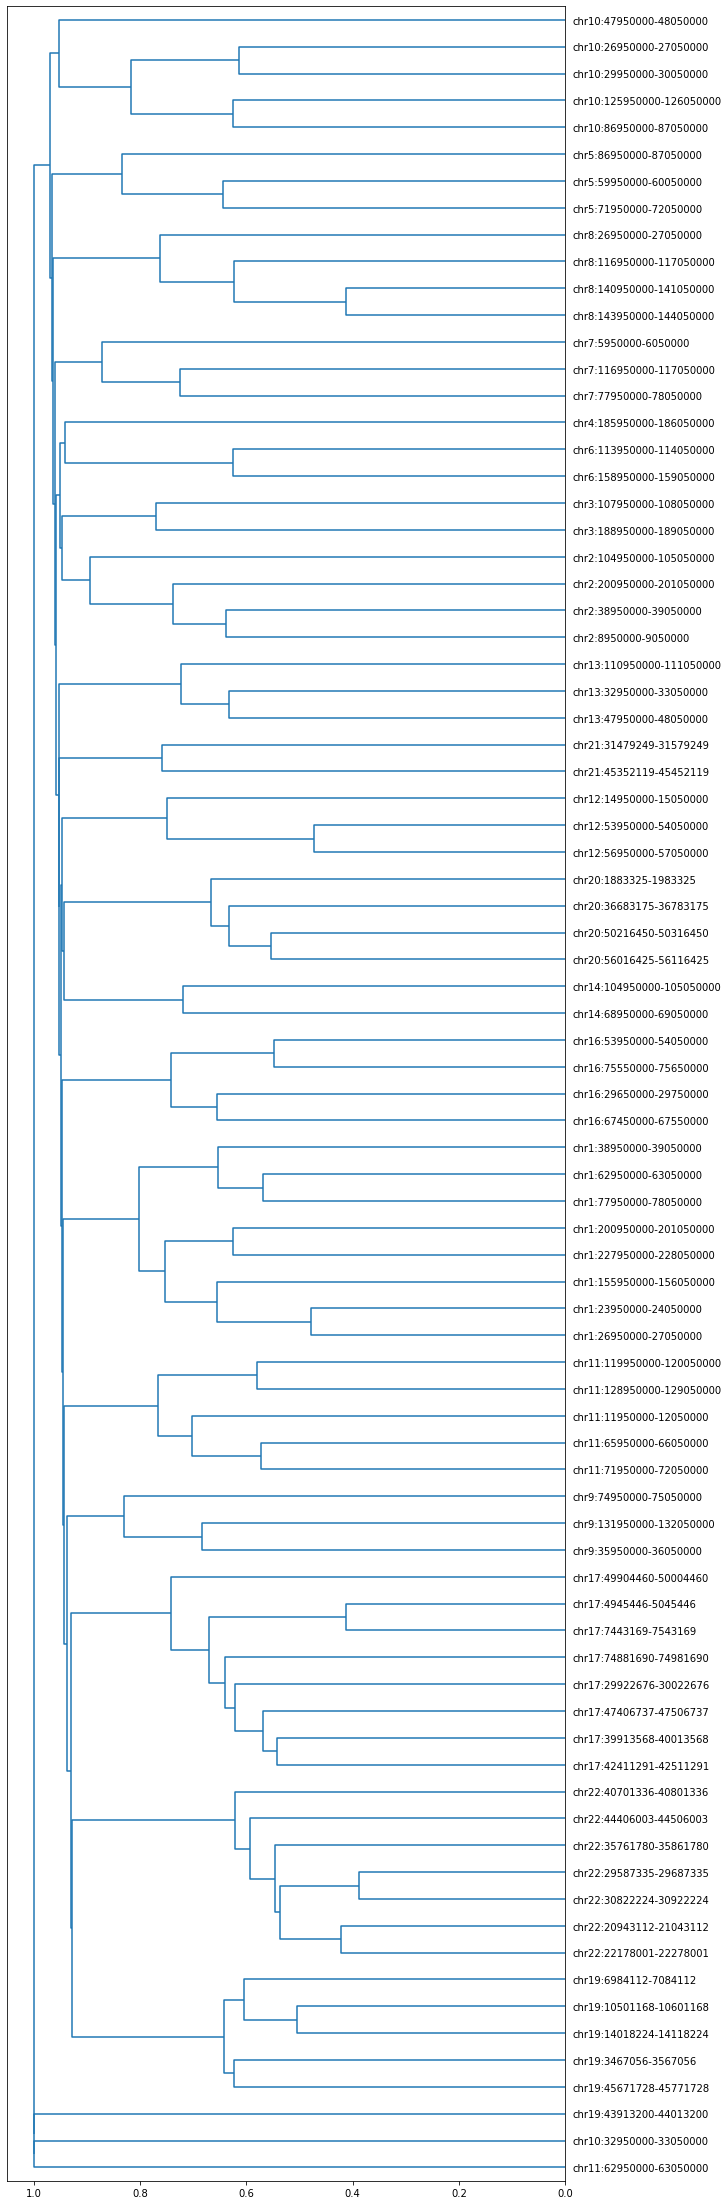

In [39]:
# Plot full dendrogram
plt.figure(figsize=(10, 40))
dendrogram( linked_hic,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            color_threshold=0)
# plt.savefig(saving_supp_dir+f'suppfig_7d_{norm}.pdf', format='pdf')
plt.show()

In [40]:
# Identify which nodes are in non-singleton clusters
probe_clusters_df = pd.DataFrame({'probe': sorted(G.nodes), 'cluster': clust_hic})
nonsingleton_cluster_ids = set([c for c in list(clust_hic) if list(clust_hic).count(c)>1])
nonsingleton_probes = probe_clusters_df[probe_clusters_df['cluster'].isin(nonsingleton_cluster_ids)]['probe'].values

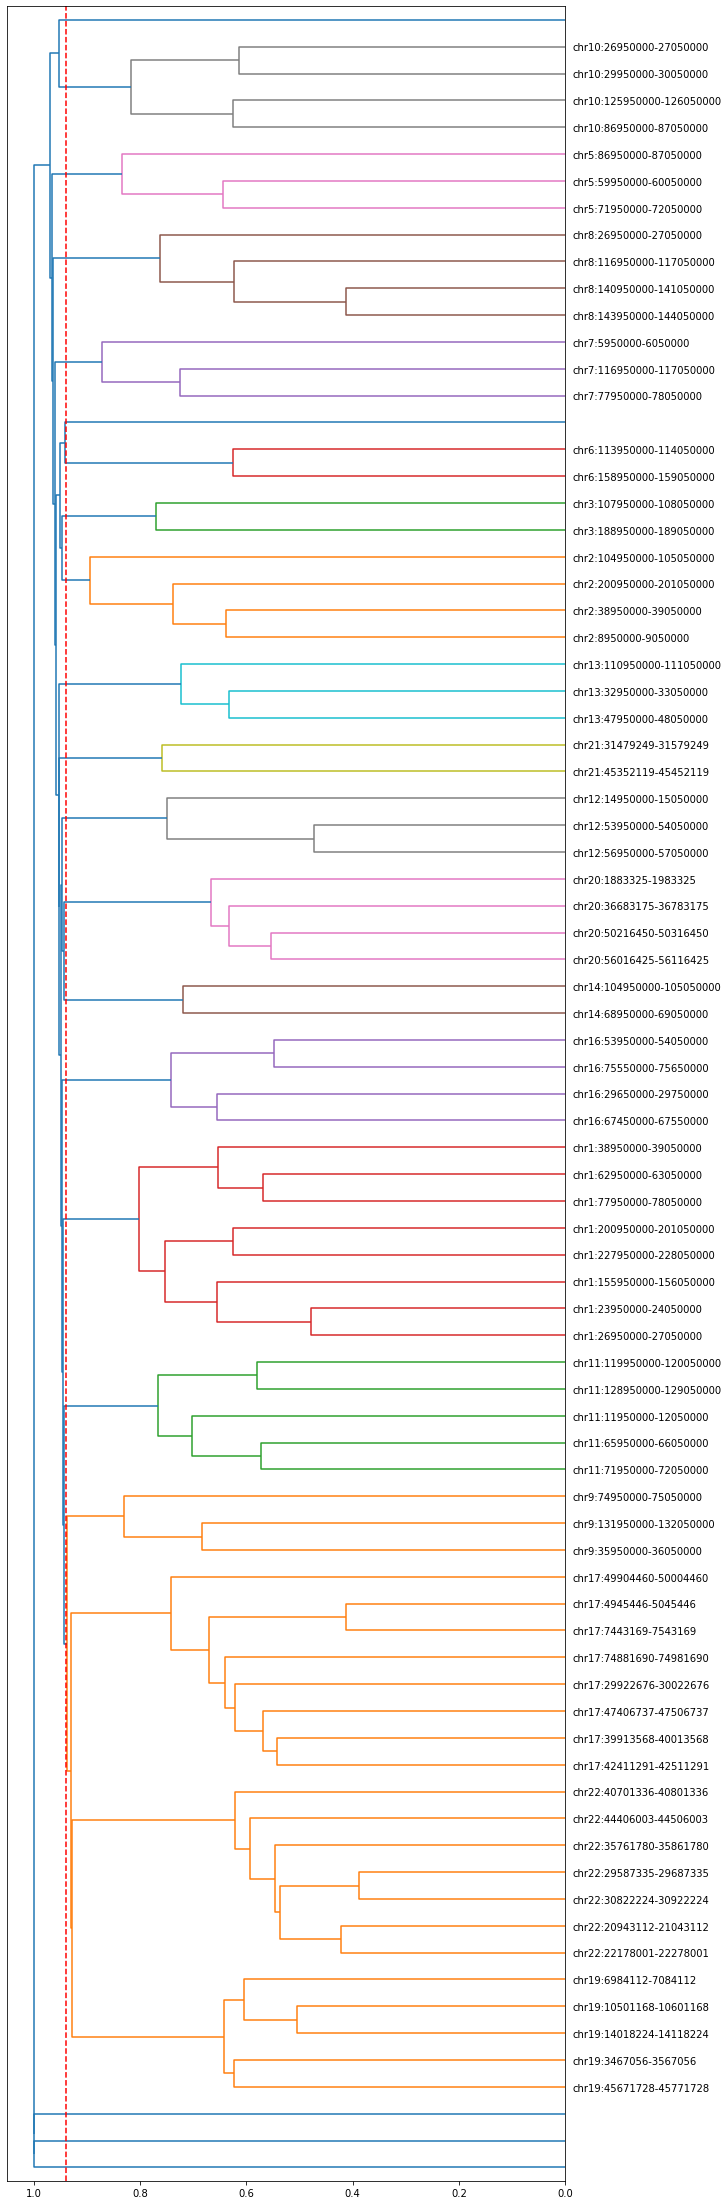

In [41]:
# Call dendrogram to get the returned dictionary and compute label function
R1 = dendrogram(linked_hic, labels=sorted(G.nodes), no_plot=True)
R2 = []
for i in range(len(R1['ivl'])):
    if (R1['ivl'][i] in nonsingleton_probes):
        R2.append(R1['ivl'][i])
    else:
        R2.append('')
# Create a label dictionary
temp = {
    R1['leaves'][ii]: R2[ii] 
    for ii in range(len(R1['leaves']))
}
def llf(xx):
    return temp[xx]

plt.figure(figsize=(10, 40))
dendrogram(linked_hic,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            leaf_label_func=llf,
            color_threshold=t_critic)
plt.vlines(x=t_critic, ymin=0, ymax=4000, color='red', linestyle='dashed')
# plt.savefig(saving_main_dir+f'fig_5c_{norm}.pdf', format='pdf')
plt.show()

# Compare clusterings

### Ordered by MERFISH clustering

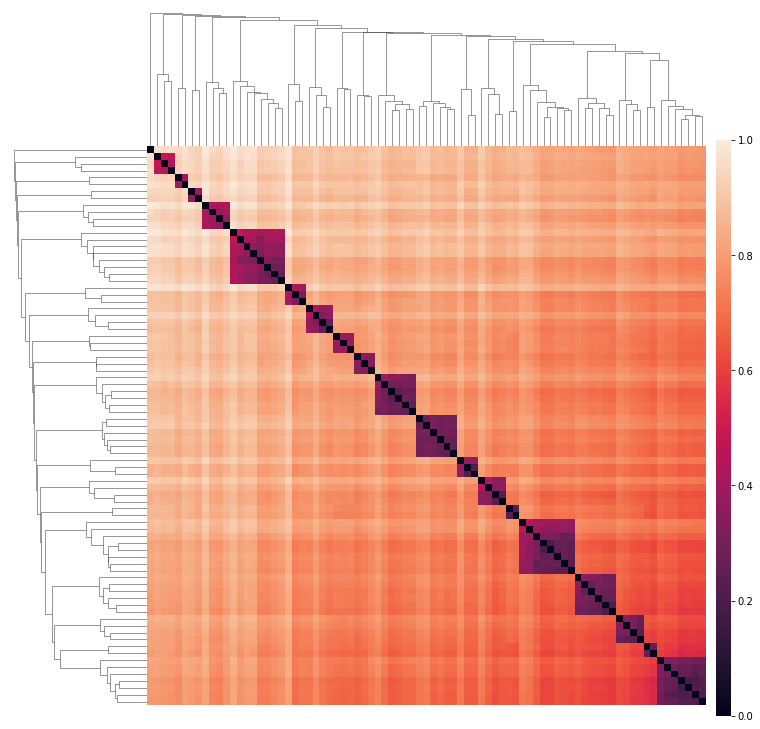

In [42]:
# Display MERFISH heatmap ordered by MERFISH distance
g = sns.clustermap(data=avg_scaled_dist_df,
                   row_cluster=True, col_cluster=True,
                   row_linkage=linked_merfish, col_linkage=linked_merfish,
                   xticklabels=False, yticklabels=False)
g.ax_heatmap.tick_params(right=False, bottom=False)
g.ax_cbar.set_position([1,0,0.02,.8])
plt.show()

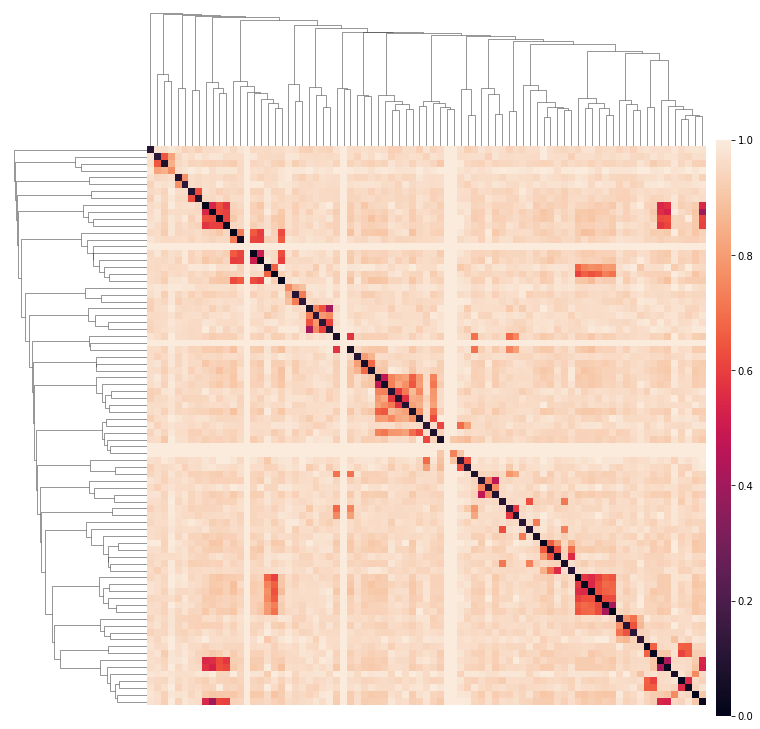

In [43]:
# Display HiC heatmap ordered by MERFISH distance
g = sns.clustermap(data=hic_scaled_dist_df,
                   row_cluster=True, col_cluster=True,
                   row_linkage=linked_merfish, col_linkage=linked_merfish,
                   xticklabels=False, yticklabels=False)
g.ax_heatmap.tick_params(right=False, bottom=False)
g.ax_cbar.set_position([1,0,0.02,.8])
plt.show()

### Ordered by HiC clustering

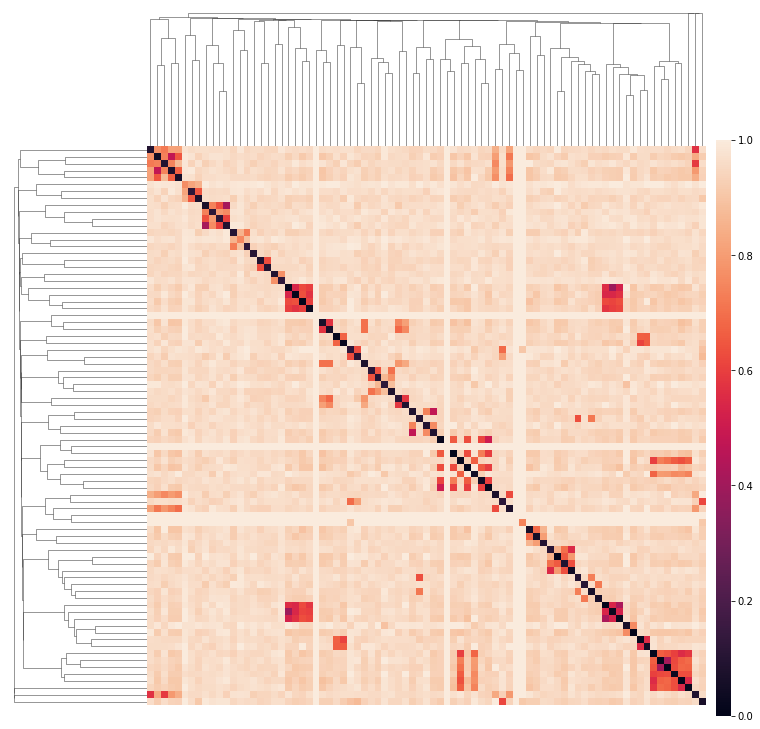

In [44]:
# Display HiC heatmap ordered by HiC distance
g = sns.clustermap(data=hic_scaled_dist_df,
                   row_cluster=True, col_cluster=True,
                   row_linkage=linked_hic, col_linkage=linked_hic,
                   xticklabels=False, yticklabels=False)
g.ax_heatmap.tick_params(right=False, bottom=False)
g.ax_cbar.set_position([1,0,0.02,.8])
plt.show()

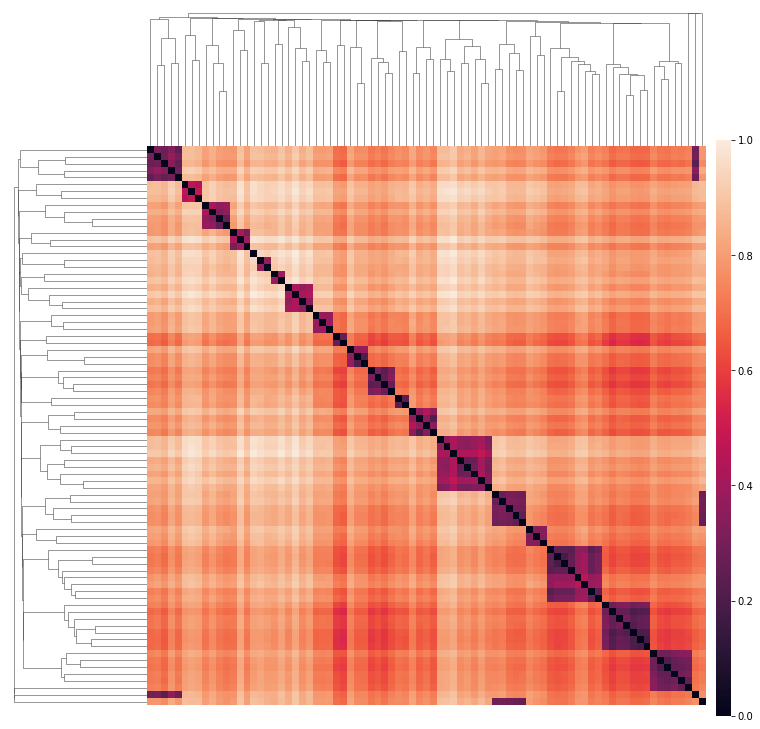

In [45]:
# Display MERFISH heatmap ordered by HiC distance
g = sns.clustermap(data=avg_scaled_dist_df,
                   row_cluster=True, col_cluster=True,
                   row_linkage=linked_hic, col_linkage=linked_hic,
                   xticklabels=False, yticklabels=False)
g.ax_heatmap.tick_params(right=False, bottom=False)
g.ax_cbar.set_position([1,0,0.02,.8])
plt.show()

### Rand Index

In [46]:
rand_score = adjusted_rand_score(labels_true=clust_merfish, labels_pred=clust_hic)
print(f'Rand score = {rand_score}')
ami_score = adjusted_mutual_info_score(labels_true=clust_merfish, labels_pred=clust_hic)
print(f'Adjusted mutual information score = {ami_score}')

Rand score = 0.5290386056869868
Adjusted mutual information score = 0.7866012114742638


### Co-clustered genes in both MERFISH and Hi-C

In [47]:
# Co-clustering matrix in HiC
dummy_clust_hic = np.concatenate([np.eye(1,len(np.unique(clust_hic)), c) for c in clust_hic], axis=0)
net_clust_hic = np.dot(dummy_clust_hic, dummy_clust_hic.T)

In [48]:
# Co-clustering matrix in MERFISH
dummy_clust_merfish = np.concatenate([np.eye(1,len(np.unique(clust_merfish)), c) for c in clust_merfish], axis=0)
net_clust_merfish = np.dot(dummy_clust_merfish, dummy_clust_merfish.T)

In [49]:
# Combine both co-clustering matrices
combined_net = net_clust_hic+net_clust_merfish
combined_net = (combined_net>1).astype(int)
combined_net = pd.DataFrame(combined_net, index=adhesome_MERFISH_probes, columns=adhesome_MERFISH_probes)

In [70]:
# Create co-clustering graph
G_clust = nx.from_pandas_adjacency(combined_net)
chrom_attribute = {k: k.split(':')[0] for k in G_clust.nodes}
nx.set_node_attributes(G_clust, chrom_attribute, "chromosome")
genes_attribute = {k: ', '.join(merfishloc2gene[k]) for k in G_clust.nodes}
nx.set_node_attributes(G_clust, genes_attribute, "genes")
oi.output_networkx_graph_as_interactive_html(G_clust, f'coclustering_graph.html')

PosixPath('/home/louiscam/projects/gpcr/code/figures4/graph.html')

In [51]:
# Only keep connected components with multiple chromosomes
cc_G_clust = np.array([c for c in nx.connected_components(G_clust)])
cc_G_clust_chroms = np.array([len({loc.split(':')[0] for loc in cc}) for cc in cc_G_clust])
cc2keep = np.where(cc_G_clust_chroms>1)[0]
multiX_cc = cc_G_clust[cc2keep]

In [52]:
# Convert to genes
multiX_cc_genes = [np.array(sorted(itertools.chain.from_iterable([merfishloc2gene[loc] for loc in cc])))
                   for cc in multiX_cc]
multiX_cc_genes

[array(['ABI1', 'ARF1', 'CSRP1', 'ITGB1', 'MAPK8', 'NRP1'], dtype='<U5'),
 array(['ADAM12', 'LDB3', 'PARVA'], dtype='<U6'),
 array(['ITGA5', 'LRP1', 'PTPRO', 'STARD13'], dtype='<U7'),
 array(['ACTN1', 'AKT1', 'ARHGEF7', 'BCAR1', 'BRF1', 'CTCF', 'MAZ', 'RB1',
        'RBL2'], dtype='<U7'),
 array(['CASS4', 'CEBPB', 'CRKL', 'GIT1', 'ITGB2', 'ITGB3', 'MAPK1', 'NF2',
        'PFN1', 'POLR2A', 'PPM1F', 'PTPN1', 'STAT3', 'TIAM1', 'TP53'],
       dtype='<U6'),
 array(['DNM2', 'GRB2', 'INSR', 'ITGA3', 'KEAP1', 'PIAS4', 'PIP5K1C',
        'PLAUR', 'PRKACA', 'RAVER1', 'SUMO2', 'VASP'], dtype='<U7')]